**Приоритизация гипотез и A/B тест**


Я — аналитик крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
В данной работе необходимо: 

1)приоритизировать гипотезы; 
    
2)запустить A/B-тест; 

3)проанализировать результаты.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Часть 1. Приоритизация гипотез.

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


В файле находятся 9 гипотез по увеличению выручки интернет-магазина с параметрами Reach, Impact, Confidence, Efforts. Для приоритизации используем ICE и RICE.

In [3]:
hypothesis['ICE'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

print((hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)).round(2))

                                          hypothesis    ICE
8  Запустить акцию, дающую скидку на товар в день...  16.20
0  Добавить два новых канала привлечения трафика,...  13.33
7  Добавить форму подписки на все основные страни...  11.20
6  Показать на главной странице баннеры с актуаль...   8.00
2  Добавить блоки рекомендаций товаров на сайт ин...   7.00
1  Запустить собственную службу доставки, что сок...   2.00
5  Добавить страницу отзывов клиентов о магазине,...   1.33
3  Изменить структура категорий, что увеличит кон...   1.12
4  Изменить цвет фона главной страницы, чтобы уве...   1.00


In [4]:
hypothesis['RICE'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']

print(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                          hypothesis   RICE
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


Вывод: При применении ICE наиболее перспективные гипотезы 8, 0, 7 и 6, а RICE показывает гипотезы 7,2,0 и 6. Скорее всего, это произошло из-за более широкого охвата у гипотезы 7, а значит будет воздействие на большее количество пользователей. Поэтому надо предложить для тестирования гипотезу 7 и возможно гипотезу 2.

Часть 2. Анализ A/B-теста

In [5]:
orders = pd.read_csv('/datasets/orders.csv')
orders.columns = orders.columns.str.lower()
display(orders.head(3))
display(orders.info())

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionid  1197 non-null   int64 
 1   visitorid      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

In [6]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.columns = visitors.columns.str.lower()
display(visitors.head(3))
display(visitors.info())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [7]:
print(orders.duplicated().sum())
print(visitors.duplicated().sum())

0
0


Дубликатов нет, можно продолжать работу.

Теперь определим куммулятивную выручку.

In [8]:
# массив уникальных пар значений дат и групп
datesGroups = orders[['date','group']].drop_duplicates()

# посчитаем сумму средних чеков

ordersAggregated = (datesGroups
                    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionid' : pd.Series.nunique, 'visitorid' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1)
                    .sort_values(by=['date','group'])
)

# Посчитаем количество пользователей

visitorsAggregated = (datesGroups
                      .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                             .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
                      .sort_values(by=['date','group']))

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cummulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cummulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cummulativeData.head(10))

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
5,2019-08-03,B,61,59,380996,1803
6,2019-08-04,A,84,77,425699,2562
7,2019-08-04,B,78,75,489567,2573
8,2019-08-05,A,109,100,549917,3318
9,2019-08-05,B,101,98,581995,3280


Построим график выручки групп

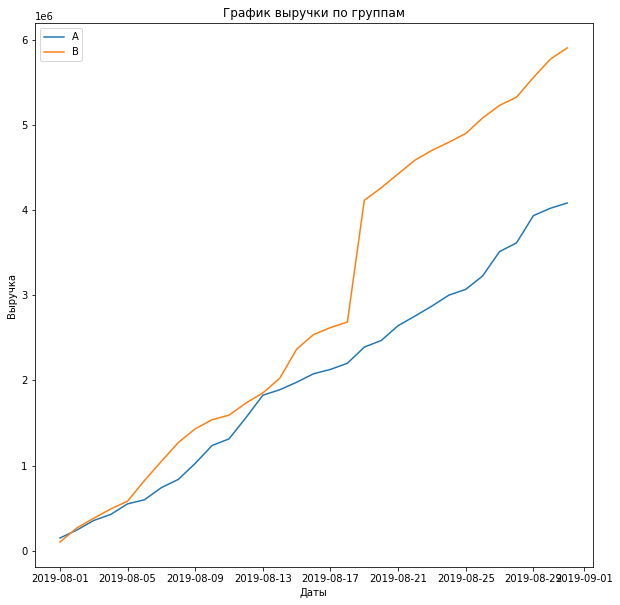

In [9]:
cummulativeRevenueA = cummulativeData[cummulativeData['group']=='A'][['date','revenue', 'orders']]
cummulativeRevenueB = cummulativeData[cummulativeData['group']=='B'][['date','revenue', 'orders']]
#поменяем формат дат
cummulativeRevenueA['date'] = pd.to_datetime(cummulativeRevenueA['date'], format='%Y-%m-%d')
cummulativeRevenueB['date'] = pd.to_datetime(cummulativeRevenueB['date'], format='%Y-%m-%d')


# Строим график выручки группы А и B

fig = plt.figure(figsize=[10,10])

plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue'], label='B')

plt.legend()
plt.title('График выручки по группам')
plt.xlabel("Даты")
plt.ylabel("Выручка")
plt.show()

Выручка увеличивается в течение всего периода, но у группы B после 2019-08-17 наблюдается резкий рост. Это может быть обьяснено появлением очень дорогих заказов, либо резким всплеском числа заказов.

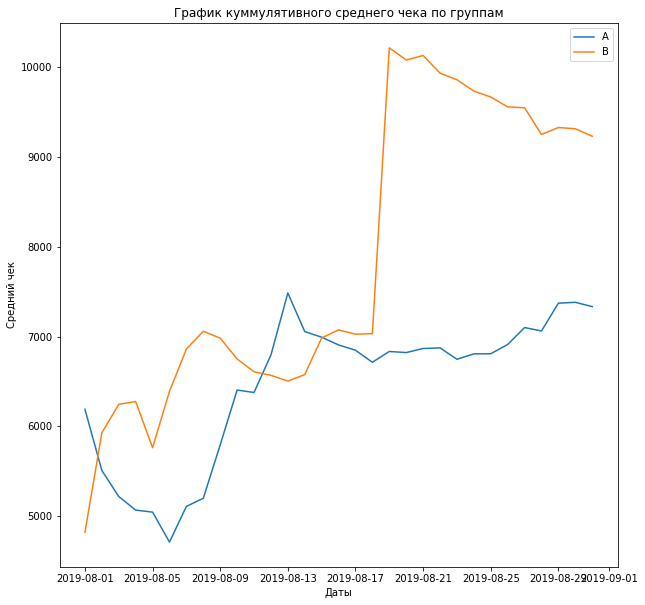

In [10]:
# построим график куммулятивного среднего чека по группам
fig = plt.figure(figsize=[10,10])
plt.plot(cummulativeRevenueA['date'], cummulativeRevenueA['revenue']/cummulativeRevenueA['orders'], label='A')
plt.plot(cummulativeRevenueB['date'], cummulativeRevenueB['revenue']/cummulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График куммулятивного среднего чека по группам')
plt.xlabel("Даты")
plt.ylabel("Средний чек")
plt.show()

В целом, наблюдаются значительные колебания, но к концу периода можно сказать, что средний чек немного растет для группы A и начинает падение для группы B. Скорее всего, данные изменения связаны с появлением особо крупных заказов в группе В.

Теперь построим график относительного различия для среднего чека.

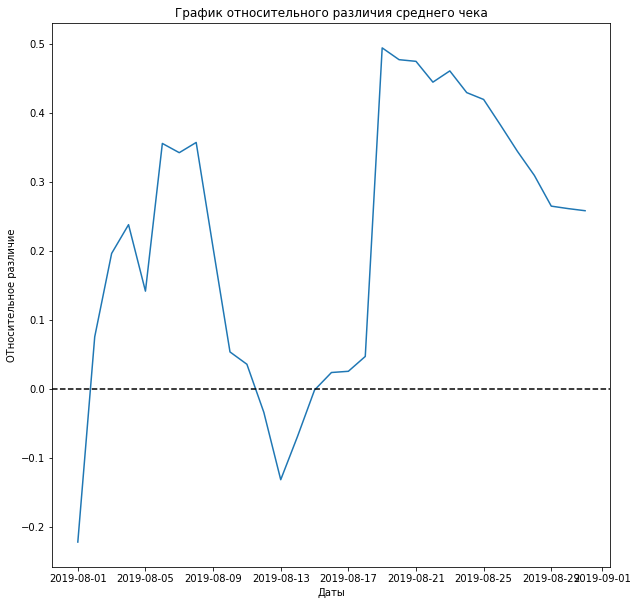

In [11]:
fig = plt.figure(figsize=[10,10])
mergedCummulativeRevenue = cummulativeRevenueA.merge(cummulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCummulativeRevenue['date'], (mergedCummulativeRevenue['revenueB']/mergedCummulativeRevenue['ordersB'])/(mergedCummulativeRevenue['revenueA']/mergedCummulativeRevenue['ordersA'])-1, label="Относительное изменение среднего чека В к А")
# добавляем ось X c 0
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного различия среднего чека')
plt.xlabel("Даты")
plt.ylabel("ОТносительное различие")
plt.show()

Наблюдаем сильные колебания. Сначала средний чек группы B растет, потом резко падает и резко растет. Возможно это влияние крупных заказов или резкий всплеск количества заказов.

Теперь посмотрим график кумулятивного среднего количества заказов по группам

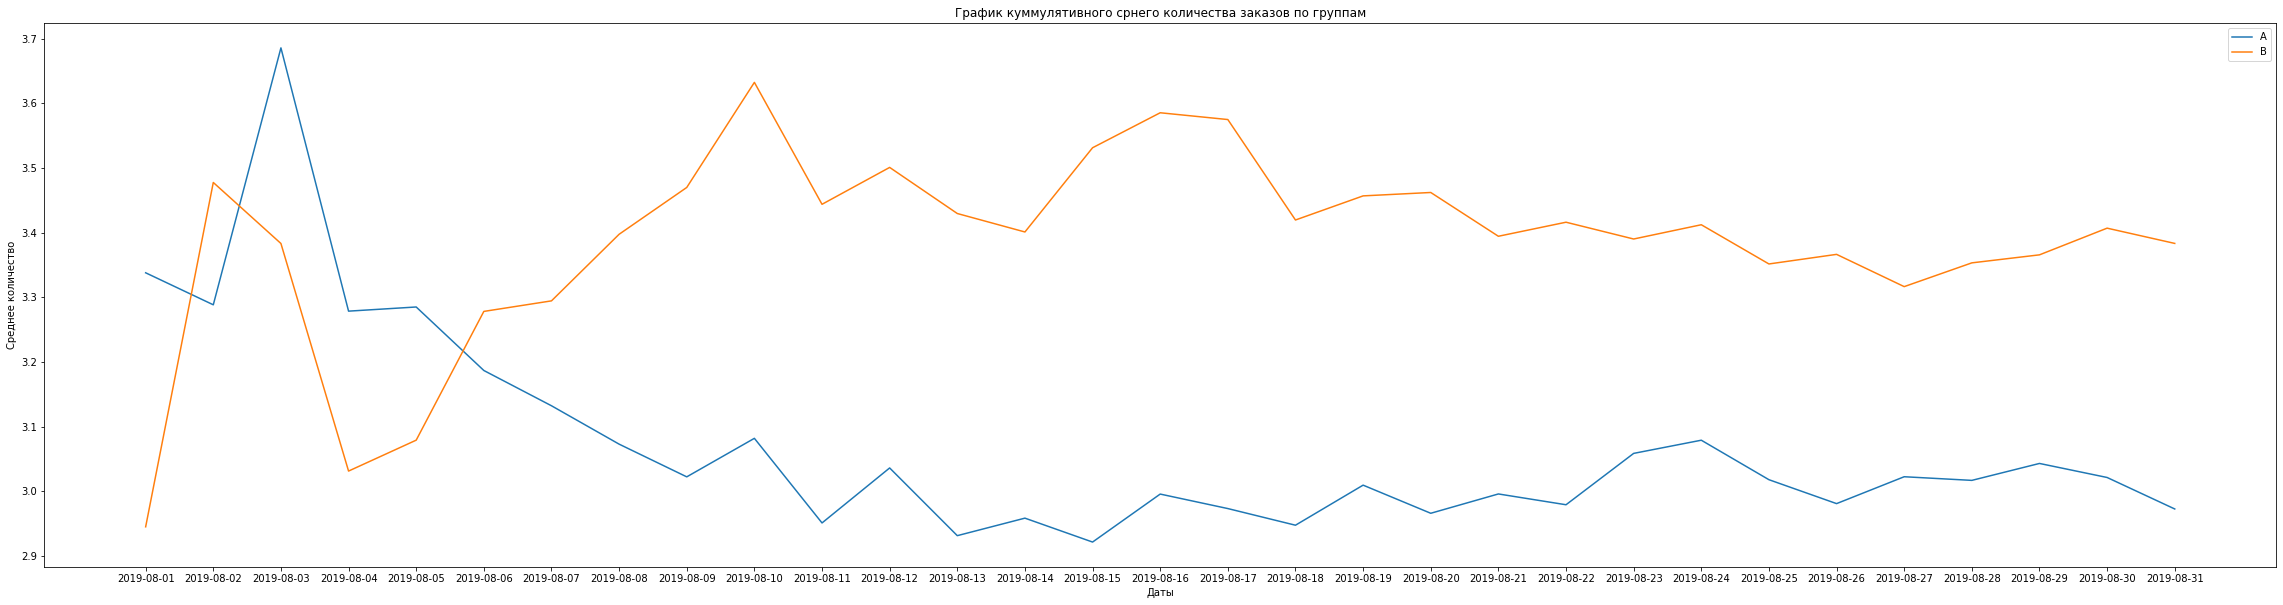

In [12]:
cummulativeOrdersA = cummulativeData[cummulativeData['group']=='A'][['date','visitors', 'orders']]
cummulativeOrdersB = cummulativeData[cummulativeData['group']=='B'][['date','visitors', 'orders']]
fig = plt.figure(figsize=[40,10])
plt.plot(cummulativeOrdersA['date'], cummulativeOrdersA['orders']/cummulativeOrdersA['visitors']*100, label='A')
plt.plot(cummulativeOrdersB['date'], cummulativeOrdersB['orders']/cummulativeOrdersB['visitors']*100, label='B')
plt.legend()
plt.title('График куммулятивного срнего количества заказов по группам')
plt.xlabel("Даты")
plt.ylabel("Среднее количество")
plt.show()

Как можно увидеть, количество заказов больше у группы В, при этом наблюдается резкий скачок с 2019-08-02 по 2019-08-03, затем падение. При этом группа А, продолжила падение, а в группе В наблюдаем обратную ситуацию.

Теперь построим график относительного изменения кумулятивного среднего количества заказов группы B к группе A.

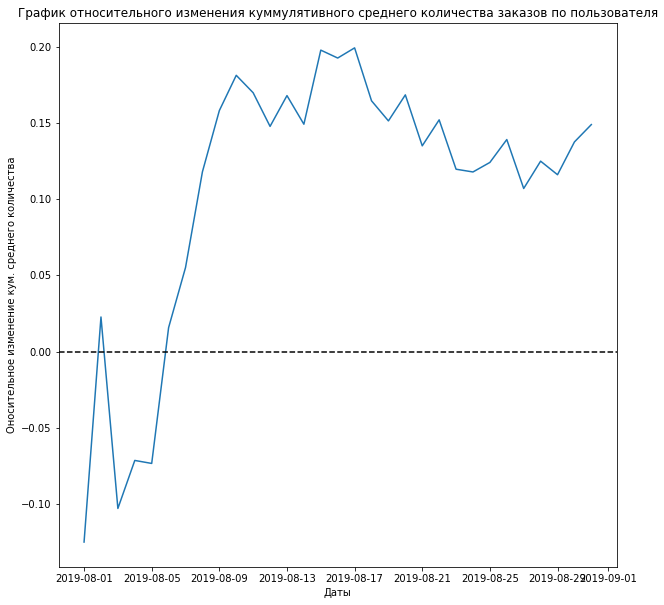

In [13]:
fig = plt.figure(figsize=[10,10])
mergedCummulativeOrders = cummulativeRevenueA.merge(cummulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCummulativeOrders['date'], (mergedCummulativeOrders['ordersB'])/(mergedCummulativeOrders['ordersA'])-1, label="Относительное изменение среднего количества заказов В к А")
# добавляем ось X c 0
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения куммулятивного среднего количества заказов по пользователя')
plt.xlabel("Даты")
plt.ylabel("Оносительное изменение кум. среднего количества")
plt.show()

Как можно увидеть, после 2019-08-05 наблюдается резкий рост количества заказов по отношеню к группе А. Это может быть вызвано аномалиями, но точно сказать нельзя.

Теперь построим точечный график количества заказов по пользователям 

In [14]:
#создадим датасет с нужными данными
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})

ordersByUsers.columns = ['visitorid','orders']

print(ordersByUsers.sort_values(by='orders',ascending=False).head(5))

       visitorid  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5


Text(0, 0.5, 'Заказы')

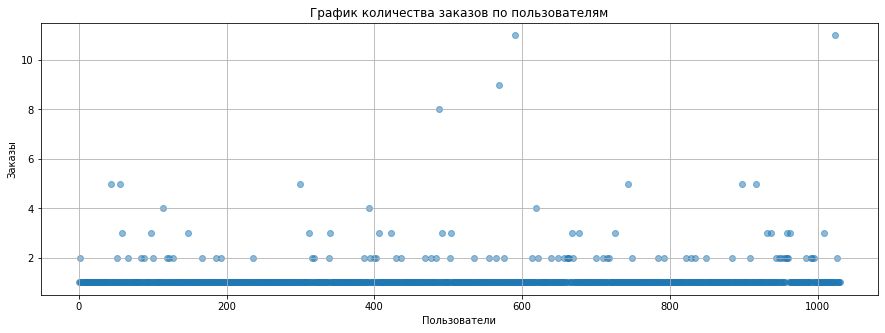

In [15]:
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.5)
plt.xlabel("Пользователи")
plt.ylabel("Заказы")

Как можно увидеть, большинство покупателей заказывали не более одного раза. Затем доли пользователей с заказами от 2 и более начинают стремительно падать. Пока нельзя сказать, являются ли они аномалиями.

In [16]:
#посчитаем 95-й и 99-й перцентили количества заказов на пользователя
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Соотвественно, примерно 95% пользователей делают 1 или 2 заказа. Значит, все, что выше - аномалии, границей выберем 2.

In [17]:
#посчитаем 95-й и 99-й перцентили стоимости заказов на пользователя
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Соответственно, менее 5% заказов стоят дороже 28000, можно взять эту цифру за границу для определения аномальных заказов.

Text(0, 0.5, 'Сумма заказа')

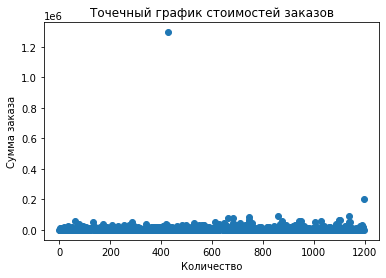

In [18]:
# строим точечный график стоимостей заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов')
plt.xlabel("Количество")
plt.ylabel("Сумма заказа")

Как можно увидеть, почти все заказы находятся в пределах 100000, но есть выброс с аномальным значением выше 1 миллиона. Именно этот заказ и отразился на всех графиках, исказив их.

Теперь посчитаем статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным. 

In [19]:
# Считаем количество пользователей до выбранной даты включительно в группах A и B;

visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# Считаем суммарное число заказов до выбранной даты включительно в группах A и B
ordersADaily = orders[orders['group']=='A'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionid', 'visitorid', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionid' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']


# создаем таблицу с количеством заказов, выручкой в день, количество заказов и выручка до выбранной даты(включительно)
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')

display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Чтобы рассчитать статистическую значимость различий в среднем количестве заказов между группами, передадим критерию mannwhitneyu() данные о количестве заказов (пороговое значение будет равно 5%). 

Нулевая гипотеза: "статистически значимых различий в средних количестве заказов между группами нет"; тогда альтернативная гипотеза: "статистически значимые различия есть".

In [20]:
# Создадим переменные ordersByUsersA и ordersByUsersB
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

ordersByUsersA = orders[orders['group']=='A'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorid', as_index=False).agg({'transactionid' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

In [21]:
#Объявим переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули.
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0) 
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("Относительный показатель 'B' к 'A' = {0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

alpha = 0.05
p-value = 0.017
Относительный показатель 'B' к 'A' = 0.138


P-value меньше 0.05. Значит, отвергаем нулевую гипотезу, то есть существуют статистически значимые различия по количеству заказов по группам.

Теперь найдем статистическую значимость различий в среднем чеке между группами. Нулевая гипотеза: "статистически значимых различий в средних чеках между группами нет"; тогда альтернативная гипотеза: "статистически значимые различия есть".

In [22]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print("Относительный показатель 'B' к 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

alpha = 0.05
p-value = 0.729
Относительный показатель 'B' к 'A' = 0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу нет. То есть средние чеки по "сырым" данным не имеют статистически значимых различий. Однако средний чек группы B на 26% больше группы А.

Теперь "очистим" данные. В результате предыдущих действий мы определили, что аномальные пользователи те, кто совершил 3 и больше заказов или совершил заказ дороже 28000 рублей. Сделаем срезы с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 28000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

In [23]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorid']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
dtype: int64


In [24]:
#посчитаем статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['visitorid'].count(),
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['visitorid'].count())[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['visitorid'].count().mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['visitorid'].count().mean() - 1))

1.000
0.184


P-value не изменился, а разница между сегментами немного возросла. Очищенные данные показывают, что средний количество заказов группы B немного больше группы A. Статистически значимых различий среднего количества заказов между группами нет.

In [25]:
#посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitorid'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.738
-0.020


P-value почти не изменился, а разница между сегментами сильно изменилась. Очищенные данные показывают, что средний чек группы B немного уступает группе A, а в сырых данных ситуация была обратная. 

Соответвенно, по очищенным данным статистически значимых различий среднего чека между группами нет.

**РЕЗУЛЬТАТЫ А/В теста**

По результатам можно сказать, что по "сырым" и по "очищенным" данным различия в средних чеках групп A и B отстутствуют, несмотря на то, что средний чек группы B оказался незначительно (на 2%) ниже среднего чека группы A по "очищенным" данным, в то время как по "сырым" данным он был больше. Соответственно, видим сильное влияние выбросов. График различия среднего чека колеблется, поэтому сделать из этого графика определённые выводы нельзя. Также график показывает, что среднее количество заказов у группы В больше, и динамика более позитивная.

По итогу можно остановить тест и зафиксировать победу группы B, в которой наблюдается  увеличение и в целом большее среднее число заказов по сравнению с группой А.